<a href="https://colab.research.google.com/github/smpark0520/ESAA/blob/main/%EB%94%A5%EB%9F%AC%EB%8B%9D_%ED%8C%8C%EC%9D%B4%ED%86%A0%EC%B9%98_%EA%B5%90%EA%B3%BC%EC%84%9C_ch7_6~7_p_417~440.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 7.6 게이트 순환 신경망(GRU)

* GRU: 게이트 메커니즘이 적용된 RNN 프레임 워크의 한 종류
* LSTM보다 구조 단순함



## 7.6.1 GRU 구조

* GRU: LSTM에서 사용하는 망각 게이트 + 입력 게이트 -> 별도의 업데이트 게이트로 구성
* 게이트 컨트롤러: 1을 출력하면 망각 게이트는 열리고 입력 게이트는 닫힘 (0을 출력하면 반대)
* 출력 게이트 없음  전체 상태 벡터가 매 단계마다 출력됨


### **망각 게이트 (reset gate)**
* 목적 : 과거정보를 적당히 초기화


  * $r_t = \sigma(W_r [h_{t-1}, x_t])$
  * $r_t \in (0,1)$: 이전 은닉 상태 $h_{t-1}$에 곱해 과거 정보 조절
* 시그모이드 함수 사용


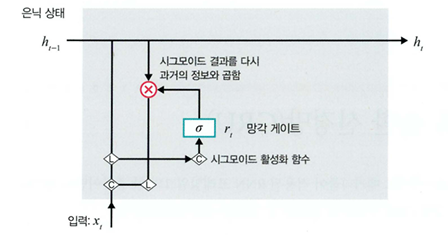

### **업데이트 게이트 (update gate)**
* 과거, 현재 정보의 최신화 비율 결정

  * $z_t = \sigma(W_z [h_{t-1}, x_t])$

* **$z_t$** → 현재 정보 비율
* **$1 - z_t$** → 이전 정보 비율
* **결과**: 과거 유지 / 새로운 정보 업데이트 균형 조절

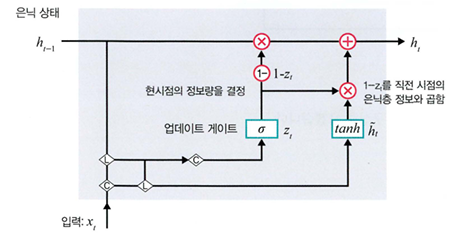

### **후보군 ($\tilde{h}_t$)**
* 현재 입력 $x_t$, 망각 게이트 적용된 이전 은닉 상태 $r_t * h_{t-1}$

  $$
  \tilde{h}_t = \tanh(W [r_t * h_{t-1}, x_t])
  $$
*  새로운 정보 반영을 위한 **잠재 상태 생성**
* 점 단위 곱(각 요소별 연산) 사용


### **은닉층 계산 $h_t$**

  * $\tilde{h}_t$: 후보군
  * $z_t$: 업데이트 게이트
* **수식**:

  $$
  h_t = (1 - z_t) * h_{t-1} + z_t * \tilde{h}_t
  $$
* 과거와 현재 정보를 **가중합**으로 결합
* **$z_t$**: 현재 정보 비중, $1 - z_t$: 과거 정보 비중


### GRU 전체 구조

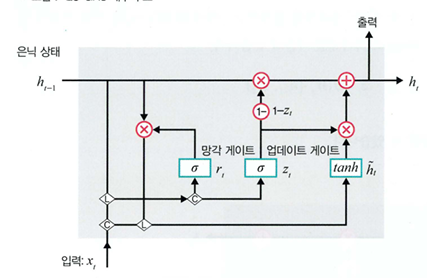

## 7.6.2 GRU 셀 구현

- 라이브러리 호출

In [3]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dataset
from torch.autograd import Variable
from torch.nn import Parameter
import torch.nn.functional as F
from torch.utils.data import DataLoader
import math

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

torch.manual_seed(125)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(125)

* **정규화**: 평균-표준편차 기준 스케일 조정
* **변환**: 데이터 → 텐서로 변환


In [4]:
mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (1.0,))
])

- 데이터셋 내려받기 및 전처리 적용

In [5]:
from torchvision.datasets import MNIST
download_root = '../chap07/MNIST_DATASET'

train_dataset = MNIST(download_root, transform=mnist_transform, train=True, download=True)
valid_dataset = MNIST(download_root, transform=mnist_transform, train=False, download=True)
test_dataset = MNIST(download_root, transform=mnist_transform, train=False, download=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 509kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.64MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.98MB/s]


- 데이터셋 메모리로 가져오기

In [6]:
batch_size = 64
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=batch_size,
                          shuffle=True)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=False)

- 변수 값 설정

In [7]:
batch_size = 100
n_iters = 6000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

- GRU 셀 네트워크

In [8]:
class GRUCell(nn.Module):
  def __init__(self, input_size, hidden_size, bias=True):
    super(GRUCell, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.bias = bias
    self.x2h = nn.Linear(input_size, 3 * hidden_size, bias=bias) # (1)
    self.h2h = nn.Linear(hidden_size, 3 * hidden_size, bias=bias)
    self.reset_parameters()

  def reset_parameters(self): # 파라미터를 초기화
    std = 1.0 / math.sqrt(self.hidden_size)
    for w in self.parameters():
      w.data.uniform_(-std, std)

  def forward(self, x, hidden):
    x = x.view(-1, x.size(1))

    gate_x = self.x2h(x) # LSTM 셀에서는 gates를 x2h+h2h로 정의. GRU 셀에서는 개별적인 상태를 유지.
    gate_h = self.h2h(hidden)
    gate_x = gate_x.squeeze()
    gate_h = gate_h.squeeze()

    i_r, i_i, i_n = gate_x.chunk(3, 1) # 총 세 개의 게이트를 위해 세개로 쪼갬.
    h_r, h_i, h_n = gate_h.chunk(3, 1)

    resetgate = F.sigmoid(i_r + h_r)
    inputgate = F.sigmoid(i_i + h_i)
    newgate = F.tanh(i_n + (resetgate * h_n)) # 새로운 게이트: 탄젠트 활성화 함수가 적용된 게이트

    hy = newgate + inputgate * (hidden - newgate)
    return hy

- 전반적인 네트워크 구조

In [9]:
class GRUModel(nn.Module):
  def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, bias=True):
    super(GRUModel, self).__init__()
    self.hidden_dim = hidden_dim
    self.layer_dim = layer_dim

    self.gru_cell = GRUCell(input_dim, hidden_dim, layer_dim) # 앞에서 정의한 GRUCell 함수를 불러온다.
    self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, x):
    if torch.cuda.is_available():
      h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).cuda())
    else:
      h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))

    outs = []
    hn = h0[0,:,:] # LSTM 셀에서는 셀 상태에 대해서도 정의했었지만 GRU 셀에서는 셀은 사용되지 않는다.

    for seq in range(x.size(1)):
      hn = self.gru_cell(x[:,seq,:], hn)
      outs.append(hn)
    out = outs[-1].squeeze()
    out = self.fc(out)
    return out

- 옵티마이저와 손실 함수 설정

In [10]:
input_dim = 28
hidden_dim = 128
layer_dim = 1
output_dim = 10

model = GRUModel(input_dim, hidden_dim, layer_dim, output_dim)

if torch.cuda.is_available():
  model.cuda()

criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

- 모델 학습 및 성능 검증

In [11]:
seq_dim = 28
loss_list = []
iter = 0
for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    if torch.cuda.is_available():
      images = Variable(images.view(-1, seq_dim, input_dim).cuda())
      labels = Variable(labels.cuda())
    else:
      images = Variable(images.view(-1, seq_dim, input_dim))
      labels = Variable(labels)

    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)

    if torch.cuda.is_available():
      loss.cuda()

    loss.backward()
    optimizer.step()

    loss_list.append(loss.item())
    iter += 1

    if iter % 500 == 0:
      correct = 0
      total = 0
      for images, labels in valid_loader:
        if torch.cuda.is_available():
          images = Variable(images.view(-1, seq_dim, input_dim).cuda())
        else:
          images = Variable(images.view(-1, seq_dim, input_dim))

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)

        if torch.cuda.is_available():
          correct += (predicted.cpu() == labels.cpu()).sum()
        else:
          correct += (predicted == labels).sum()

      accuracy = 100 * correct / total
      print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 1.6616928577423096. Accuracy: 43.59000015258789
Iteration: 1000. Loss: 0.8945668935775757. Accuracy: 76.19999694824219
Iteration: 1500. Loss: 0.29147759079933167. Accuracy: 89.7300033569336
Iteration: 2000. Loss: 0.23627907037734985. Accuracy: 93.51000213623047
Iteration: 2500. Loss: 0.03288722783327103. Accuracy: 95.05000305175781
Iteration: 3000. Loss: 0.030374936759471893. Accuracy: 95.81999969482422
Iteration: 3500. Loss: 0.1621057391166687. Accuracy: 96.33999633789062
Iteration: 4000. Loss: 0.19308771193027496. Accuracy: 96.19000244140625
Iteration: 4500. Loss: 0.05172014236450195. Accuracy: 97.0
Iteration: 5000. Loss: 0.13900171220302582. Accuracy: 97.26000213623047
Iteration: 5500. Loss: 0.08090294897556305. Accuracy: 97.62000274658203
Iteration: 6000. Loss: 0.10488354414701462. Accuracy: 97.69000244140625
Iteration: 6500. Loss: 0.07984036952257156. Accuracy: 97.80000305175781
Iteration: 7000. Loss: 0.10250388830900192. Accuracy: 97.55999755859375
Iteration

- 테스트 데이터셋을 이용한 모델 예측

In [12]:
def evaluate(model, val_iter):
  corrects, total, total_loss = 0, 0, 0
  model.eval()
  for images, labels in val_iter:
    if torch.cuda.is_available():
      images = Variable(images.view(-1, seq_dim, input_dim).cuda())
    else:
      images = Variable(images.view(-1, seq_dim, input_dim)).to(device)

    logit = model(images).to(device)
    loss = F.cross_entropy(logit, labels, reduction='sum')
    _, predicted = torch.max(logit.data, 1)
    total += labels.size(0)
    total_loss += loss.item()
    corrects += (predicted == labels).sum()

  avg_loss = total_loss / len(val_iter.dataset)
  avg_accuracy = corrects / total
  return avg_loss, avg_accuracy

- 모델 예측 결과

In [13]:
test_loss, test_acc = evaluate(model, test_loader)
print('Test Loss: %5.2f | Test Accuracy: %5.2f' % (test_loss, test_acc))

Test Loss:  0.07 | Test Accuracy:  0.98


* 예측 정확도 98%
* LSTM과 성능 비슷
* MNIST에선 성능이 좋지만 다른 데이터셋에선 낮게 나올 수 있으므로 다양한 모델 적용 필요



## 7.6.3 GRU 계층 구현

* GRU 계층에 대한 PyTorch를 이용한 예제 실습
* LSTM 예제와 데이터셋 및 코드 유사
* 모델 네트워크 위주로 학습


In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
data = pd.read_csv('/content/drive/MyDrive/OB/OB_dataset/SBUX.csv')
print(data.dtypes)

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object


* 'Date' 칼럼을 인덱스로 지정
* 'Volume' 칼럼을 float 형식으로 변경
* 대소문자 구분!


In [17]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data['Volume'] = data['Volume'].astype(float)

- 전제 칼럼 중 마지막 칼럼을 제외한 모든 데이터셋을 x(훈련 용도)로 지정
- 마지막 칼럼을 레이블(y)로 지정

In [18]:
X = data.iloc[:, :-1]
y = data.iloc[:, 5:6]
print(X)
print(y)

                  Open        High         Low       Close   Adj Close
Date                                                                  
2019-12-11   86.260002   86.870003   85.849998   86.589996   84.145752
2019-12-12   88.000000   88.889999   87.540001   88.209999   85.720032
2019-12-13   88.019997   88.790001   87.580002   88.669998   86.167046
2019-12-16   89.139999   89.300003   88.430000   88.779999   86.273941
2019-12-17   88.870003   88.970001   87.470001   88.129997   85.642288
...                ...         ...         ...         ...         ...
2020-12-04  101.349998  102.940002  101.070000  102.279999  101.442787
2020-12-07  102.010002  102.220001  100.690002  101.410004  100.579918
2020-12-08  100.370003  101.570000  100.010002  101.209999  100.381554
2020-12-09  101.940002  102.209999  100.099998  100.400002   99.578186
2020-12-10  103.510002  106.089996  102.750000  105.389999  104.527336

[253 rows x 5 columns]
                Volume
Date                  
2019-12

- 앞에서 정의한 훈련과 레이블 데이터셋을 정규화하여 분포 조정

In [19]:
ms = MinMaxScaler()
ss = StandardScaler()

X_ss = ss.fit_transform(X)
y_ms = ms.fit_transform(y)

X_train = X_ss[:200, :]
X_test = X_ss[200:, :]

y_train = y_ms[:200, :]
y_test = y_ms[200:, :]

print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape)

Training Shape (200, 5) (200, 1)
Testing Shape (53, 5) (53, 1)


- 데이터셋을 LSTM 네트워크에 적용하기 위해 형태를 변경

In [20]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_f = torch.reshape(X_train_tensors, (X_train_tensors.shape[0],
                                                    1, X_train_tensors.shape[1]))
X_test_tensors_f = torch.reshape(X_test_tensors, (X_test_tensors.shape[0],
                                                  1, X_test_tensors.shape[1]))

print("Training Shape", X_train_tensors_f.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_f.shape, y_test_tensors.shape)

Training Shape torch.Size([200, 1, 5]) torch.Size([200, 1])
Testing Shape torch.Size([53, 1, 5]) torch.Size([53, 1])


- GRU 모델의 네트워크

In [21]:
class GRU(nn.Module):
  def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
    super(GRU, self).__init__()
    self.num_classes = num_classes
    self.num_layers = num_layers
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.seq_length = seq_length

    self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
    self.fc_1 = nn.Linear(hidden_size, 128)
    self.fc = nn.Linear(128, num_classes)
    self.relu = nn.ReLU()

  def forward(self, x):
    h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) # 은닉 상태에 대해 0으로 초기화하는 부분으로, LSTM 계층은 셀 상태가 있었지만 GRU는 셀 상태를 정의하지 않는다.
    output, (hn) = self.gru(x, (h_0))
    hn = hn.view(-1, self.hidden_size)
    out = self.relu(hn)
    out = self.fc_1(out)
    out = self.relu(out)
    out = self.fc(out)
    return out

- 옵티마이저와 손실 함수 지정

In [22]:
num_epochs = 1000
learning_rate = 0.0001

input_size = 5
hidden_size = 2
num_layers = 1 # GRU 계층의 개수

num_classes = 1
model = GRU(num_classes, input_size, hidden_size, num_layers, X_train_tensors_f.shape[1])

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

- 모델 학습

In [23]:
for epoch in range(num_epochs):
  outputs = model.forward(X_train_tensors_f)
  optimizer.zero_grad()
  loss = criterion(outputs, y_train_tensors)
  loss.backward()

  optimizer.step()
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.09152
Epoch: 100, loss: 0.04470
Epoch: 200, loss: 0.04107
Epoch: 300, loss: 0.03851
Epoch: 400, loss: 0.03446
Epoch: 500, loss: 0.02795
Epoch: 600, loss: 0.02165
Epoch: 700, loss: 0.01847
Epoch: 800, loss: 0.01753
Epoch: 900, loss: 0.01734


- 그래프 출력을 위한 전처리

In [24]:
df_x_ss = ss.transform(data.iloc[:, :-1])
df_y_ms = ms.transform(data.iloc[:, -1:])

df_x_ss = Variable(torch.Tensor(df_x_ss))
df_y_ms = Variable(torch.Tensor(df_y_ms))
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1]))

-  모델의 예측 결과와 레이블을 비교하여 그래프로 출력

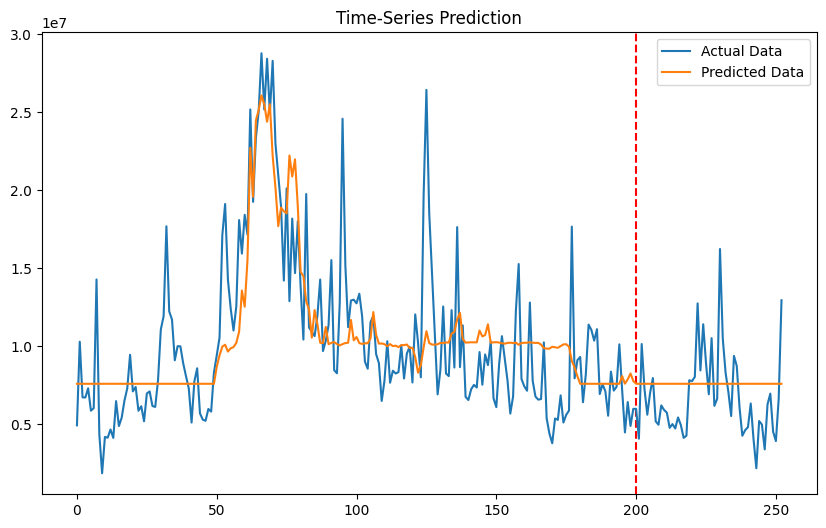

In [25]:
train_predict = model(df_x_ss)
predicted = train_predict.data.numpy()
label_y = df_y_ms.data.numpy()

predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)
plt.figure(figsize=(10,6))
plt.axvline(x=200, c='r', linestyle='--')

plt.plot(label_y, label='Actual Data')
plt.plot(predicted, label='Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

* 그래프상 GRU가 LSTM보다 예측력 좋아 보임
* 수치상으로는 정확도는 유사


# 7.7 양방향 RNN

* RNN은 이전 시점의 데이터만 참고하여 정답 예측
* 이후 시점의 데이터도 함께 활용하는 것이 양방향 RNN


## 7.7.1 양방향 RNN 구조

* 메모리 셀 2개 사용
* 순방향 셀: 과거 은닉 상태 활용
* 역방향 셀: 미래 은닉 상태 활용
* 두 은닉 상태를 합쳐 출력층에 전달

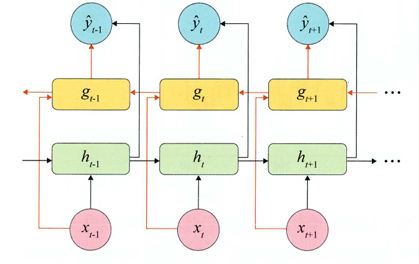

* 양방향 구조는 RNN, LSTM, GRU 모두 적용 가능
* 예제는 양방향 LSTM으로 구현


## 7.7.2 양방향 LSTM 구현

* 스타벅스 주가 예측 데이터셋 사용
* 네트워크 구조 중심으로 양방향 LSTM 차이 확인


- 모델을 생성하고 학습

In [26]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

data = pd.read_csv('/content/drive/MyDrive/OB/OB_dataset/SBUX.csv')
print(data.dtypes)

data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data['Volume'] = data['Volume'].astype(float)

X = data.iloc[:, :-1]
y = data.iloc[:, 5:6]

ms = MinMaxScaler()
ss = StandardScaler()
X_ss = ss.fit_transform(X)
y_ms = ms.fit_transform(y)

X_train = X_ss[:200, :]
X_test = X_ss[200:, :]
y_train = y_ms[:200, :]
y_test = y_ms[200:, :]

X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_f = torch.reshape(X_train_tensors, (X_train_tensors.shape[0],
                                                    1, X_train_tensors.shape[1]))
X_test_tensors_f = torch.reshape(X_test_tensors, (X_test_tensors.shape[0],
                                                  1, X_test_tensors.shape[1]))

print("Training Shape", X_train_tensors_f.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_f.shape, y_test_tensors.shape)

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object
Training Shape torch.Size([200, 1, 5]) torch.Size([200, 1])
Testing Shape torch.Size([53, 1, 5]) torch.Size([53, 1])


- 모델의 네트워크

In [27]:
class biLSTM(nn.Module):
  def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
    super(biLSTM, self).__init__()
    self.num_classes = num_classes
    self.num_layers = num_layers
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.seq_length = seq_length

    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                        num_layers=num_layers, bidirectional=True, batch_first=True) # (1)
    self.fc = nn.Linear(hidden_size*2, num_classes) # (2)
    self.relu = nn.ReLU()

  def forward(self, x):
    h_0 = Variable(torch.zeros(self.num_layers*2, x.size(0), self.hidden_size)) # (2)'
    c_0 = Variable(torch.zeros(self.num_layers*2, x.size(0), self.hidden_size)) # (2)''
    out, _ = self.lstm(x, (h_0, c_0))
    out = self.fc(out[:, -1, :]) # 마지막 시간(time step상 마지막 단계)의 은닉 상태
    out = self.relu(out)
    return out



* `nn.LSTM(~  bidirectional=True)`: 양방향 LSTM 사용하겠다는 의미
* `hidden_size * 2`: 양방향이라 출력 크기 2배
* `h_0`, `c_0`: 레이어 수 × 2로 초기화 (forward + backward)
* `out[:, -1, :]`: 시퀀스 마지막 시점의 출력만 사용
* `fc`: 예측 결과를 위한 fully connected layer
* `ReLU`: 최종 출력에 비선형성 추가


-  양방향 LSTM 모델을 학습

In [28]:
num_epochs = 1000
learning_rate = 0.0001

input_size = 5
hidden_size = 2
num_layers = 1
num_classes = 1
model = biLSTM(num_classes, input_size, hidden_size, num_layers, X_train_tensors_f.shape[1])

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
  outputs = model.forward(X_train_tensors_f)
  optimizer.zero_grad()

  loss = criterion(outputs, y_train_tensors)
  loss.backward()
  optimizer.step()
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.14172
Epoch: 100, loss: 0.14172
Epoch: 200, loss: 0.14172
Epoch: 300, loss: 0.14172
Epoch: 400, loss: 0.14172
Epoch: 500, loss: 0.14172
Epoch: 600, loss: 0.14172
Epoch: 700, loss: 0.14172
Epoch: 800, loss: 0.14172
Epoch: 900, loss: 0.14172


* 오차 감소 → 훈련 잘됨
* 그래프로 예측력 확인


-  모델 평가

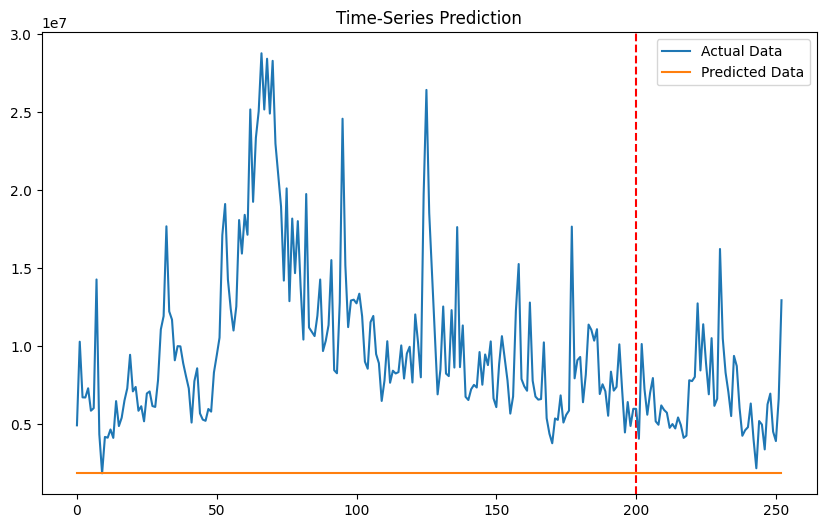

In [29]:
df_x_ss = ss.transform(data.iloc[:, :-1])
df_y_ms = ms.transform(data.iloc[:, -1:])

df_x_ss = Variable(torch.Tensor(df_x_ss))
df_y_ms = Variable(torch.Tensor(df_y_ms))
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1]))

train_predict = model(df_x_ss)
predicted = train_predict.data.numpy()
label_y = df_y_ms.data.numpy()

predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)
plt.figure(figsize=(10,6))
plt.axvline(x=200, c='r', linestyle='--')

plt.plot(label_y, label='Actual Data')
plt.plot(predicted, label='Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

* 파란색: 실제
* 주황색: 예측
* 두 곡선 유사하므로 예측력 좋음
* LSTM과 유사하거나 더 좋은 성능

